# Basics of Mobile Robotics Project - Group 21

**Team Members:** Marc Mouawad, Muratcan
Akgün, Sara Heidaripour, Rayan Bouchallouf. 

**Supervisor:** Professor Francesco Mondada

**Date:** 05.12.2024


## Table of Contents: 

<ol>
<li>Introduction</li>
<li>Vision Module</li>
<li>Global Navigation</li>
<li>Kalman Filter</li>
<li>Local Navigation and Motion Control</li>
<li>Local Obstacle Avoidance</li>
<li>Main</li>
<li>Conclusion</li>
</ol>

# 1. Introduction

In this project, an environment is developed so that the Thymio, a differential drive robot, can navigate autonomously to reach a desired goal. 

This environment consists of 5 ArUco markers. The first one placed on the Thymio itself, while the other four represent the corners of a map with size 1189 by 841 mm. The thymio will then attempt to reach the goal (a green object) while following an optimal path computed using the A* algorithm. While doing so, the thymio will avoid any global obstacle (red objects)thanks to the computed path along with motion control, and avoid any local obstacle thanks to the feedback from its on-board proximity sensors and an ANN-based reactive routine. Note that the Thymio will also be robust to kidnapping and to the camera being hidden for short periods of time thanks to a Kalman Filter.

The different files inside this folder are: 

<ol>
<li>vision.py : Vision Module class</li>
<li>kalman.py : Kalman Filter class</li>
<li>control.py : Controller class</li>
<li>A_star_planner.py : A* global planner class</li>
<li>Group_T21_report.ipynb : Containing the report explaining our pipeline, along with the test code to run the system, and some code showing results for individual parts.</li>
</ol>


## 2. Vision Module

This module consists of multiple parts. The final goal of the vision module, is to detect the map, the Thymio, and find an occupancy grid containing obstacles and a start and goal locations to pass to the A* planner. Moreover, if the camera is hidden or the robot is kidnapped, this routine is to start again once we receive feedback from the camera. 

### ArUco Marker detection and tracking:

The class Vision_Module takes as argument the list of marker IDs it might encounter.

These markers consist of black and white squares with a specific size, which represent a binary matrix. This matrix contains values encoding the marker's identifier (ID). 
In order to detect the markers, we first define as a class attribute the object ArucoDetector, which takes as parameters a marker dictionary containing all the predefined markers the detector might encounter.  

Using the "aruco" module of OpenCV, we are able to detect all the corners and IDs of all markers on the image. Using the corner of each marker and the function from the aruco module of cv2 cv2.aruco.estimatePoseSingleMarkers we find the orientation and position of each marker embedded in rvec and tvec. Then using the cv2.ProjectPoints() we find from tvec the camera coordinates of the marker's center. The function gives as output the position of the center as well as the points representing the x-y-z frames of the corner on the image. Hence using the x-axis point we can also compute the orientation of the robot (when ID = 0, which is the Thymio marker's ID).

We do this process for the four map corners and for the marker on the Thymio.


REFERENCES: 

https://docs.opencv.org/3.4/d9/d6a/group__aruco.html

https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html


In [ ]:
import cv2
import numpy as np
def detect_markers_and_robot(self, frame):
        # QR detection (to be put in a function alone)
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    corners, ids, _ = self.marker_detector.detectMarkers(gray)
    map_centers = []

    if ids is not None and len(ids)>=1:
        # sort the corners and ids in increasing order of ID: 0,1,2,3,4.
        sorted_pairs = sorted(zip(ids.flatten(), corners), key=lambda x: x[0])
        ids, corners = zip(*sorted_pairs)

        if len(ids) == 5:
            self.camera_working = True
        else:
            self.camera_working = False

        for (marker, id) in zip(corners, ids):
            if id in [1,2,3,4]:
                index = np.where(ids == id)[0][0]
                corner = corners[index] # find corners of the marker
                # get orientation and positions 
                rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corner, self.marker_length, self.camera_mtx, self.dist_coeffs)
                # define points representing the frame of the markers
                points = np.float32([[0, 0, 0], [self.axis, 0, 0], [0, self.axis, 0], [0, 0, -self.axis]]).reshape(-1, 3, 1)
                # project these to the camera frame
                axis_points, _ = cv2.projectPoints(points, rvecs[0],tvecs[0],self.camera_mtx,self.dist_coeffs)
                # convert them to type int
                axis_points = axis_points.astype(int)
                cx, cy = axis_points[0].ravel() # get the coordinates of the center
                map_centers.append([int(cx),int(cy)])
                cv2.circle(frame, (int(cx), int(cy)), 4, (255, 255, 1), 2) # draw a circle around the center

            elif id == 0:
                # find the position of the thymio
                index_thymio = np.where(ids==id)[0][0]
                # find the corner
                corner_thymio = corners[index_thymio]
                # same as above
                rvecs_thymio,tvecs_thymio,_ = cv2.aruco.estimatePoseSingleMarkers(corner_thymio, self.marker_length, self.camera_mtx, self.dist_coeffs)
                points_thymio = np.float32([[0, 0, 0], [self.axis, 0, 0], [0, self.axis, 0], [0, 0, -self.axis]]).reshape(-1, 3, 1)
                axis_points_thymio, _ = cv2.projectPoints(points_thymio, rvecs_thymio[0],tvecs_thymio[0],self.camera_mtx,self.dist_coeffs)
                axis_points_thymio = axis_points_thymio.astype(int)
                self.thymio_position[0] = axis_points_thymio[0].ravel()[0]
                self.thymio_position[1] = axis_points_thymio[0].ravel()[1]
                self.thymio_xframe = axis_points_thymio[1].ravel()

    self.map_centers = map_centers

### Homography and Frame Warping

Hence, we first find the map corners coordinates on the image, then, we define a Homography to map the selected map corners in the image plane to a new plane of size equal to the size of the map. Note that the corners of the map will be mapped to the corners of the plane, with the top-left map corner mapped to the origin.

We use this mapping to warp the image, and obtain a top down view of the map, robot and obstacles.

Once this matrix and frame are obtained, any point on the image fram can be mapped to a real-world coordinate since the Homography matrix coefficients embed transformations such as perspective scaling, rotations, and translation. 

REFERENCES: 

https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html


https://www.productteacher.com/quick-product-tips/homography-for-computer-vision-product-managers#:~:text=Homography%20is%20a%20concept%20in,different%20camera%20angles%20or%20positions.


In [ ]:
import constants
def warp_to_top_view(self, frame, dst_size=constants.MAP_DIMENSIONS): 
    # this computes the homography matrix and maps our frame to real world!
    """
    Warps the camera's perspective to align with a top-down view.
    
    Args:
        frame: The original camera frame.
        src_points: Detected 4 ArUco marker points in the image.
        dst_size: The desired size of the output top-down view.
        
    Returns:
        warped_frame: The top-down view of the frame.
        homography_matrix: The homography matrix used for the transformation.
    """
    # Define destination points for the top-down view
    dst_points = np.array([
        [0, 0],  # Top-left
        [dst_size[0] - 1, 0],  # Top-right
        [dst_size[0] - 1, dst_size[1] - 1],  # Bottom-right
        [0, dst_size[1] - 1]  # Bottom-left
    ], dtype=np.float32)

    # Compute the homography matrix
    src_points = np.array(self.map_centers,dtype=np.float32)
    homography_matrix, _ = cv2.findHomography(src_points, dst_points)
    # Warp the frame to the top-down view
    warped_frame = cv2.warpPerspective(frame, homography_matrix, dst_size)

    return warped_frame, homography_matrix

Next on the list come obstacles and goal detection. For simplicity in this project, the global obstacles are assumed to be red, while the goal is assumed to be green. 

These obstacles are detected by first converting our warped frame to the HSV frame, where each color has specific [H,S,V] values, where H is color specific and varies from 0 to 180, and S,V vary depending on the lighting. Higher lighting would require lower S-values. For simplicity and based on the references attached with the code in "vision.py", V is set equal to S when the values are tuned.

Hence, we check which pixels in the frame correspond to the colors red and green (note two different functions are defined in the class for more simplicity), and we pick them aside. Morphological operations, such as opening and closing are applied to the obtained binary mask, from which we extract contours of the mask and finally a bounding box giving the range of coordinates of obstacles and goal. Note that the obstacles are enlarged by half the radius of the Thymio to avoid any collision while navigating.


REFERENCES:

https://docs.opencv.org/3.4/df/d9d/tutorial_py_colorspaces.html

https://stackoverflow.com/questions/36817133/identifying-the-range-of-a-color-in-hsv-using-opencv

In [ ]:
def detect_obstacle(self, frame):
    """
    Detects a red obstacle in the given frame.
    """
    # Convert the frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define HSV range for detecting dark blue
    lower_red = np.array([160, 100, 100])  # Lower bound of red in HSV
    upper_red = np.array([180, 255, 255])  # Upper bound of red in HSV

    # Create a mask for the blue object
    mask = cv2.inRange(hsv, lower_red, upper_red)
    # Apply morphological operations to clean the mask
    kernel = np.ones((4, 4), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    obstacles = []

    for contour in contours:
        # Filter small contours based on area
        if cv2.contourArea(contour) > 500:  # Adjust threshold as needed
            # Compute the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Store information about the obstacle
            if h >60 and w>60 :
                offset = 0
                obstacles.append((x-offset,y-offset,w+offset,h+offset)) # add bounding box information
    self.obstacles = obstacles

def detect_goal(self,frame): # find a blue goal

    # Convert the frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define HSV range for detecting dark blue
    lower_green = np.array([36, 60, 60])  # Lower bound of green in HSV
    upper_green = np.array([89, 255, 255])  # Upper bound of green in HSV

    # Create a mask for the blue object
    mask = cv2.inRange(hsv, lower_green, upper_green)
    # Apply morphological operations to clean the mask
    kernel = np.ones((4, 4), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    for contour in contours:
        # Filter small contours based on area
        if cv2.contourArea(contour) > 500:  # Adjust threshold as needed
            # Compute the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Store information about the obstacle
            if h >30 and w>30 :
                self.goal = [x,y,w,h] # add bounding box information

Finally, using the extracted coordinates of the thymio, obstacles, and goal, we generate grid points based on a hyper-parameter "NUM_CELLS", and compute an occupancy grid which can be sent to the A* algorithm. 

In [ ]:
def grid_points(self,frame,n_cell):
    if len(self.map_centers) == 4:
        rows, cols = n_cell, n_cell
        grid_points = []
        col_total, row_total = constants.MAP_DIMENSIONS
        for row in range(1,rows):
            row_points = []
            for col in range(1,cols):
                x = col * (col_total/cols)
                y = row * (row_total/rows)
                # Draw the points on the original frame
                if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                    cv2.circle(frame, (int(x), int(y)), 4, (255, 0, 0), -1)
                    row_points.append((int(x), int(y)))
            grid_points.append(row_points)
    self.real_world_grid_points = grid_points

def find_occupancy_grid(self, grid_points, frame):
    """
    Updates the occupancy grid based on the grid points, obstacles, and goal.

    Args:
        grid_points: List of grid points.
        obstacles: List of obstacles (bounding boxes).
        goal: The goal bounding box.
        frame: The original frame for visualization.

    Returns:
        occupancy_grid: A 2D array representing the grid map.
    """
    rows = len(self.real_world_grid_points)
    cols = len(self.real_world_grid_points[0])

    self.occupancy_grid = np.zeros((constants.NUM_CELLS,constants.NUM_CELLS))
    self.goals_location = []

    # Mark obstacles in the occupancy grid
    enlargement = 60
    for obstacle in self.obstacles:
        x, y, w, h = obstacle
        for i in range(rows):
            for j in range(cols):
                px, py = self.real_world_grid_points[i][j]
                if x-enlargement <= px <= (x + w+ enlargement) and (-enlargement+y) <= py <= (y + h + enlargement):
                    self.occupancy_grid[i, j] = 1  # Obstacle

        # Mark the goal in the occupancy grid
        if self.goal:
            gx, gy, gw, gh = self.goal
            for i in range(rows):
                for j in range(cols):
                    px, py = self.real_world_grid_points[i][j]
                    if gx <= px <= gx + gw and gy <= py <= gy + gh:
                        self.occupancy_grid[i, j] = 2  # Goal
                        self.goals_location.append([px,py])    


Once, the path is received, it is also visualized on the warped frame. Note that, this whole operation is computed once in the first two seconds of the run, then in case any change of state happens to the thymio (such as kidnapping, local avoidance, or the hidden camera for a period of time).

In [ ]:
def visualize_path_on_frame(self,warped_frame, path, grid_points):
    """
    Visualizes the path on the warped frame by mapping grid indices to pixel coordinates.

    Args:
        warped_frame: The top-down view of the map (warped frame).
        path: List of indices representing the path found by the planner.
        grid_points: 2D list of pixel coordinates corresponding to grid points.
    """
    if path is None:
        print("No path found to visualize.")
        return

    # Convert grid indices to pixel coordinates
    pixel_path = [grid_points[idx[0]][idx[1]] for idx in path]
    real_world_path = []
    # Draw the path on the warped frame
    for i in range(len(pixel_path) - 1):
        # Draw lines between consecutive points
        start = pixel_path[i]
        end = pixel_path[i + 1]
        cv2.line(warped_frame, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), (255, 0, 255), 2)
        

    # Highlight the start and goal positions
    cv2.circle(warped_frame, (int(pixel_path[0][0]), int(pixel_path[0][1])), 6, (0, 0, 255), -1)  # Start (red)
    cv2.circle(warped_frame, (int(pixel_path[-1][0]), int(pixel_path[-1][1])), 6, (255, 0, 0), -1)  # Goal (blue)

    return pixel_path

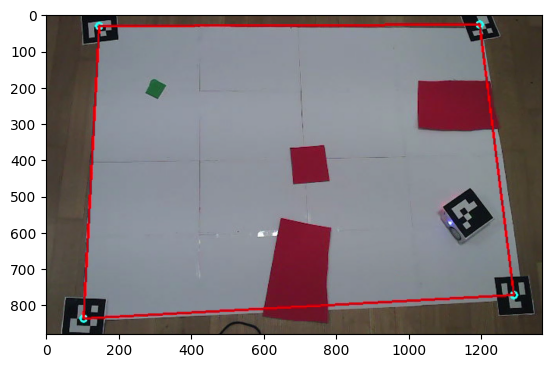

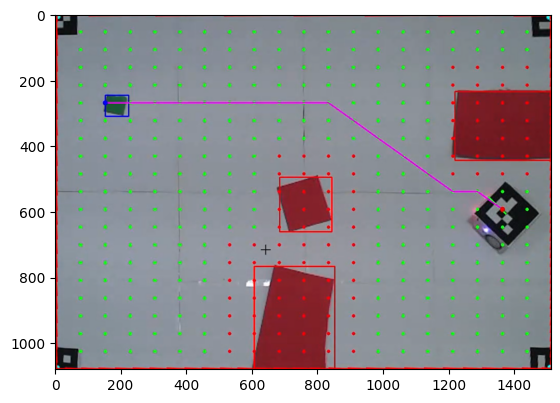

In [ ]:
"""
The function showing all functionalities for the vision part can be found in vision.py, it is called main_vision()
In this cell we include the result of all the processing of the images to show the end result of the vision module.

Note that since this function requires the markers to run we do not include a test code in this case, but only end results
more can be seen from the vision module in the demo videos

Note the two images do not show the same time instant, they are simply example of images from different experiments

"""
import matplotlib.pyplot as plt 
f = plt.imread("./images/original_frame.png")
plt.imshow(f)
plt.show() 
f = plt.imread("./images/global_navigation.png")
plt.imshow(f)
plt.show() 


## 3. Global Navigation and Path Planning

In this part of the project, global navigation is being implemented. This functionality is defined in the code as the `A_star_Planner` class. In this class, the optimal path from the robot's current position to the goal is calculated using the A* algorithm.

First, using data from vision (start and goal positions, and occupancy grid), the planner is initialized. Due to the resolution of the grid, multiple cells may be occupied by the goal. Consequently, the goal point passed to the A* algorithm is chosen as the closest cell to the start position (the robot's current position).

The heuristic function of the A* algorithm is the Euclidean distance, which allows diagonal paths to be generated for greater optimality. All eight neighboring cells surrounding the current cell are considered candidates for the next position. This means the robot can move to any of these eight neighbors (i.e., Up, Down, Right, Left, Up-Right, Up-Left, Down-Right, and Down-Left) in its next step. The movement cost (`g_cost`) is assumed to be the same for all neighbors.

In the implementation of the A* algorithm, a priority queue (`heapq`) is used with `heappush` and `heappop` to efficiently select the node with the lowest cost.

Here we show an example of the A* planner on some toy data.

REFERENCE:

Exercise Session 5 -- BOMR 

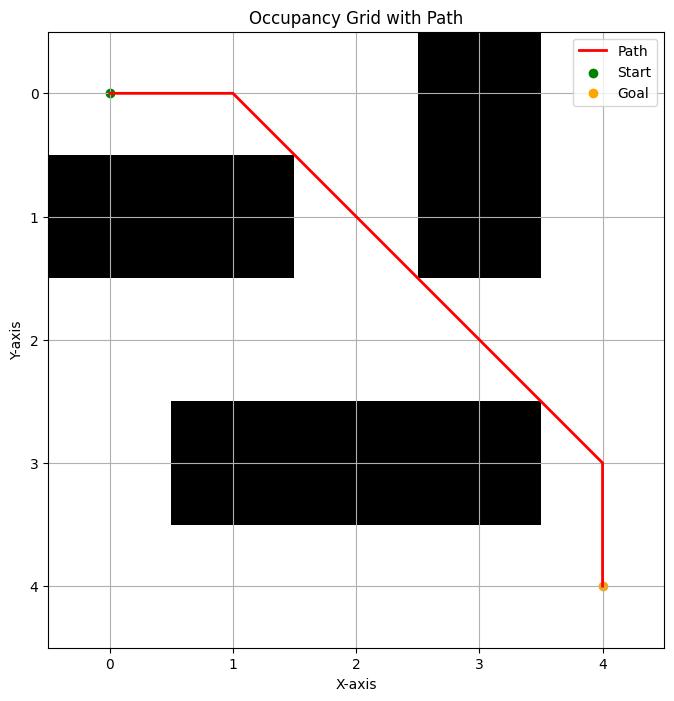

In [ ]:
# Include the A_star_Planner class code here
"""
Here we show a test case of our A* algorithm, 
the refinement of this test case was made using chat gpt, however chat gpt 
was not used to generate codes other than simulations to make sure our system was working
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import A_star_planner
# Generate a simple test occupancy grid (5x5 grid for simplicity)
grid = np.array([
    [0, 0, 0, 1, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

# Define the start position and goal positions
start_position = (0, 0)  # Top-left corner
goal_positions = [(4, 4)]  # Bottom-right corner

# Initialize the A* planner
plannner = A_star_planner.A_star_Planner(grid, start_position, goal_positions)

# Perform the A* search
pathh = plannner.a_star_search()

# Plot the occupancy grid and path
plt.figure(figsize=(8, 8))
cmap = ListedColormap(['white', 'black'])  # White for free, black for obstacles
plt.imshow(grid, cmap=cmap)
plt.title("Occupancy Grid with Path")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Highlight the path
if pathh:
    path_x, path_y = zip(*pathh)
    plt.plot(path_y, path_x, color="red", linewidth=2, label="Path")
    

# Highlight start and goal
plt.scatter(start_position[1], start_position[0], color="green", label="Start")
for goal in goal_positions:
    plt.scatter(goal[1], goal[0], color="orange", label="Goal")

plt.legend()
plt.grid(True)
plt.show()


## 4. Kalman Filter

For the filtering part, Kalman Filter is decided to be used as it is more computationally efficient than particle filter, and the real-time performance is important for this setup. Moreover, based on the chosen states, and since the experiments are happening in a controlled environment, it can be assumed that the data will follow a normal distribution.

As the motion model of a differential drive robot is nonlinear, "Extended Kalman Filter" is decided to be used.

REFERENCE: inspired by the ideas of https://arxiv.org/pdf/1204.0375

## Filter Related Parameters

We need to define the states and the control inputs in order to build a motion model. In this implementation the state vector is considered as the position and the orientation, and the control inputs are linear and angular velocities. Thus, $$ x = \begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}$$ $$ u = \begin{bmatrix}
v \\
\omega
\end{bmatrix} $$

Also, there are $ Q $ and $ R $ matrices, which are process noise and measurement noise matrices respectively, are tuned accordingly. The process noise matrix is tuned by hand to optimize the performance of the filter, and the measurement noise matrix is chosen according to measurements taken from the camera.

Namely, the thymio is placed at a known position of the camera, namely the center, with an orientation of 90 degrees. The states are measured using the 
main_vision() function of vision.py and the measurement noise covariance matrix is found to have diagonal elements equal to: 
[0.061185577823367526, 0.08187993622437 ,0.050204178187361818] 

In the cell below, we show a sample code plotting the distribution of the taken y measurements, confirming their distribution is close to gaussian.

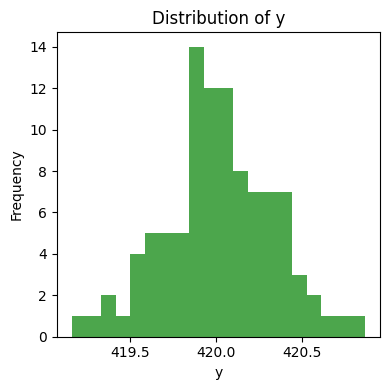

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the text file
data = np.loadtxt("camera_data.txt", skiprows=1)

# Extract columns
x = data[:, 0]
y = data[:, 1]
theta = data[:, 2]

# Plot the distributions
plt.figure(figsize=(4, 4))
plt.hist(y, bins=20, color='green', alpha=0.7)
plt.title('Distribution of y')
plt.xlabel('y')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Motion Model: 

For the implementation of the EKF, first we need to derive the model of the system. From the theoretical part of the course, the equations for the position and the orientation of the robot can be written as, $$x_{t+1} = x_{t} + v*\cos(\theta_{t})*\Delta t $$ $$y_{t+1} = y_{t} + v*\sin(\theta_{t})*\Delta t $$ $$ \theta_{t+1} = \theta_{t} + \omega*\Delta t$$

where $v$ is the linear speed, $\omega$ is the angular speed and $\Delta t$ is the time step.

This model is implemented in the EKF class as follows,

In [ ]:
def motion_model(self, state, control):
        """
        Nonlinear motion model.
        :param state: Current state [x, y, theta, v, omega]
        :param control: Control inputs [v, omega]
        :return: Predicted next state
        """
        x, y, theta = state
        v, omega = control  # Control inputs: velocity and angular velocity
        new_state = np.array([
            x + v * np.cos(theta) * self.dt,
            y + v * np.sin(theta) * self.dt,
            theta + omega * self.dt,
        ])
        while np.abs(new_state[2]) > np.pi:
            if new_state[2] < 0:
                new_state[2]+=2*np.pi
            else:
                new_state[2]-=2*np.pi

        return new_state

## Prediction Step

State prediction is done by the motion model and additionally, we need to predict the state covariance which is given by $$P_{t} = F_t P_{t-1} F_t^\top + Q$$

where $Q$ is the process noise covariance noise matrix.

For the prediction step, we need the Jacobian of the motion model with respect to the states, denoted by the matrix $F_{t}$. where $$ F_t = \frac{\partial f}{\partial x} $$

So, $$ F_t = \begin{bmatrix}
1 & 0 & -v_t \sin(\theta_t) \Delta t \\
0 & 1 & v_t \cos(\theta_t) \Delta t  \\
0 & 0 & 1
\end{bmatrix} $$

The function for calculating the Jacobian is implemented as,

In [ ]:
def jacobian_F(self, state, control):
        """
        Jacobian of the motion model with respect to the state.
        :param state: Current state [x, y, theta, v, omega]
        :param control: Control inputs [v, omega]
        :return: Jacobian matrix (5x5)
        """
        _, _, theta = state
        v , _ = control
        return np.array([
            [1, 0, -v * np.sin(theta) * self.dt],
            [0, 1,  v * np.cos(theta) * self.dt],
            [0, 0, 1]
        ])

Hence the implementation of the prediction step in Python is

In [ ]:
def predict(self, control):
        """
        EKF predict step.
        :param control: Control inputs [v, omega]
        """
        # Compute Jacobian of the motion model
        F = self.jacobian_F(self.x, control)

        # Predict state
        self.x = self.motion_model(self.x, control)

        # Predict covariance
        self.P = F @ self.P @ F.T + self.Q

## Update Step

In the update step the main goal is to correct the state estimates and covariance by using the measured sensor data. There are multiple steps in the update.

### Residual Calculation: 

In this step, the error between the sensor measurement and the predicted measurement is computed. The formula is as follows, $$ y = z - h(x_{t-1})$$

where $y$ is the residual, $z$ is the measurement from sensor and $h()$ is the identity function as the states are directly observed.

### Innovation Covariance:

This step calculates the covariance of the error which represents the uncertainty in the residual. It is computed by $$ S = H P_{t-1} H^\top + R$$

where $S$ is the innovation covariance, $H$ is the Jacobian of the measurement model with respect to the state (3x3 identity matrix in this case as it is an identity transformation), $P_{t-1}$ is the predicted covariance matrix and $R$ is the measurement noise covariance matrix.

The implementation of the measurement model and its Jacobian is straightforward,



In [ ]:
def measurement_model(self, state):
    return state  # Identity mapping for simplicity

def jacobian_H(self, state):
    return np.eye(3)

### Kalman Gain Calculation: 

Kalman gain is computed in this step, which determines how much importance is given to the measurements and to the predictions for determination of the state estimate. It is found by $$ K = P_{t-1} H^\top S^{-1}$$

where $K$ is the Kalman gain.

### State Update: 

The state estimate is updated based on the Kalman gain, so $$ x_{t} = x_{t-1} + K y $$

### Covariance Update: 

The state covariance is also updated so that the uncertainty is reduced after taking into account the measurements. It is given by $$ P_{t} = (I - K H) P_{t-1} $$

The whole updating process is coded as,

In [ ]:
def update(self):
    """
    EKF update step.
    :param z: Measurement vector [x, y, theta, v, omega]
    """
    # Compute Jacobian of the measurement model
    H = self.jacobian_H(self.x)

    # Compute Kalman gain
    S = H @ self.P @ H.T + self.R
    K = self.P @ H.T @ np.linalg.inv(S)

    # Update state
    y = self.z - self.measurement_model(self.x)  # Measurement residual
    if np.abs(y[2]) > np.pi:
        if y[2]>0:
            y[2]-=2*np.pi
        elif y[2]<0:
            y[2]+=2*np.pi
    self.x = self.x + K @ y

    # Update covariance
    I = np.eye(len(self.x))
    self.P = (I - K @ H) @ self.P

### NOTE: 
We make sure the orientation as well as the orientation component of the innovation are always between -$\pi$ and $\pi$ so that we have stable behavior during the experiments.

Finally, we observe some results from experiments, the plots here show the measurement from the camera, the estimated kalman state, and the motion model prediction, 
for the x-position of the robot over time.

We can see how the kalman filter ends up filtering the prediction step of the motion model.

In this case we do not see major differences with the camera measurements as they are absolute with relatively low variances. It is important to note that when the camera
is hidden, the measurement noise covariance matrix diagonal elements are changed to very high values so that the filter ignores the measurements during this step. Hence, it would rely solely on the motion model, which over a long period of time, and considering the drifts that might happen, error would accumulate and the robot might not arrive to the goal.

However, in this case, the process noise matrix Q was tuned accordingly to maximize the period of time for which the robot can move while the camera is hidden, note that drifts are still observed after some time.

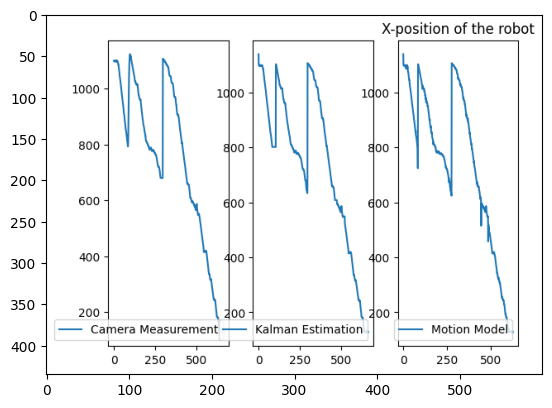

In [ ]:
f = plt.imread("./images/output_kalman.png")
plt.imshow(f)
plt.show()

## 5. Local Navigation and Motion Control:


![Control scheme from one waypoint to another](./images/control_method.png)

In this section of the report, once the real-world path is found through A* and the vision module, this module will control the robot to move along the path from one waypoint to the other. 

### Control Method: 

The controller, given the current estimate from the Kalman filter, and the desired waypoint, will compute the distance to the next waypoint called $\rho$, and if it is less than some threshold, we switch to the next waypoint.

However, if we have not reached the current waypoint, we compute the current difference vector $\delta = (\hat{x} -x_d)$, then compute its orientation as $\gamma = arctan(\frac{\delta_y}{\delta_x})$ hence we find the angle correction to be: 

$\alpha = \gamma - \hat{\theta}$. 

Now we feed two types of control law based on whether the angle error is still too high:

We set the wheel velocities to $w_r = K_p\alpha$ with Kp = 2 for the right wheel velocity, and $w_l = -K_p\alpha$ for the left wheel velocity.

If the angle error is smaller than 10 degrees: 

Kp = 0.02 and we set the left wheel velocity to $w_l = V_{base} - K_p\alpha$ and the right wheel velocity to $w_r = V_{base} + K_p\alpha$.

Below, we show a simulation for the controller, given a set of three waypoints, we can see it is able to follow the points.
The value of Kp was tuned to reach these values as they gave better performance, mainly on the Thymio this gain resulted in the best tracking.

REFERENCE:

Slides of the first lesson BOMR

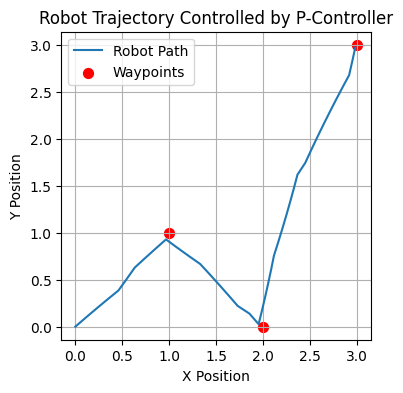

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control

"""
The refinement of this simulation was made with the help of Chat GPT. 
"""

def simulate_controller(controller, waypoints, steps=100000, dt=0.001):
    """
    Simulates robot motion with the controller.
    """
    x, y, theta = 0.0, 0.0, 0.0  # Initial state
    wheel_base = 0.1  # Distance between wheels

    trajectory = [(x, y)]  # Store trajectory

    for _ in range(steps):
        if len(waypoints) == 0:
            break

        # Current target waypoint
        x_des, y_des = waypoints[0]

        # Get control commands
        w_l, w_r = controller.get_controller_commands([x, y], theta, [x_des, y_des])

        # Convert wheel speeds to velocity and angular velocity
        v = (w_l + w_r) / 2
        omega = (w_r - w_l) / wheel_base

        # Update state
        theta_rad = np.deg2rad(theta)
        x += v * np.cos(theta_rad) * dt
        y += v * np.sin(theta_rad) * dt
        theta += np.rad2deg(omega * dt)

        theta = (theta + 360) % 360  # Normalize theta to [0, 360]

        trajectory.append((x, y))

        # Check if robot is close to the waypoint
        if np.linalg.norm([x - x_des, y - y_des]) < 0.1:
            waypoints.pop(0)

    return trajectory


# Waypoints and controller initialization
waypoints = [[1, 1], [2, 0], [3, 3]]
controler = control.Controller()
original_waypoints = np.array(waypoints)  # Copy the waypoints for plotting
# Run simulation
trajectory = simulate_controller(controler, waypoints, dt=0.001)

# Convert results to NumPy arrays
trajectory = np.array(trajectory)
if len(waypoints) > 0:
    waypoints = np.array(waypoints)

# Plot results
plt.figure(figsize=(4, 4))
plt.plot(trajectory[:, 0], trajectory[:, 1], label="Robot Path")
if len(original_waypoints) > 0:
    plt.scatter(original_waypoints[:, 0], original_waypoints[:, 1], color='red', label="Waypoints", s=50)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Robot Trajectory Controlled by P-Controller")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

## 6. Local Obstacle Avoidance:

<img src="./images/ANN_robot_control.png" alt="Description" width="300">


The implementation of obstacle avoidance is carried out by the function `local_avoidance`, which is located in the last lines of the main loop. For this implementation, an artificial neural network (ANN) composed of a single layer with two neurons is used. This ANN establishes full connections between the proximity sensors and the two motors. The inputs to this network are the values from the proximity sensors. These values are scaled, multiplied by their corresponding weights, and then summed to output the speed, which is added to the initial speed of each wheel. The appropriate weights, $w_{il}$ (for the left wheel) and $w_{ir}$ (for the right wheel), for $i \in [1, 7]$ (since there are 7 proximity sensors), have been tuned empirically through trial and error.

Finally, when the robot avoids a local obstacle, it moves forward to make sure the obstacle is not laterally close to it. Then the camera is prompted back to compute the path.

REFERENCE: Exercise Session 3 -- BOMR

## 7. Main Loop

In the cells below, all the previous parts are combined to form a system representing our environment.

In the first part we initialize our asynchronous client to setup the communication between the Laptop and the Thymio.

We also initialize two of our states, 

STATE_CHANGE = 0 if in global navigation and 1 if in local navigation.

FOLLOW_PATH: dictates whether we are following the path or not call this function at all.

In [6]:
from tdmclient import ClientAsync
import numpy as np
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
STATE_CHANGE = 0 # state of the navigation method, 0 for global, 1 for local
FOLLOW_PATH =  True # state of the controller 

Here, we define a helper function to help us send commands to the Thymio

In [7]:
def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

<img src="./images/full_pipline.jpg" alt="Description" width="600">


As shown in the Figure, the modules are initialized: 

1- Vision Module.
2- Kalman Filter.
3- Controller.
4- Path Planner. 

The loop starts with the camera performing all the required detection as mentioned in Section 2, then the Kalman Filter performs its prediction and update step depending whether the camera is working or not. 

Then we enter the controller section and follow the path, or ignore this if the robot is currently in local avoidance mode.
Finally, we read the sensor values sent from the thymio about the proximity sensors and enter local avoidance mode if they exceed a threshold. 

It is also important to note that, since when the camera stops being hidden it recomputes the path, then when the robot is kidnapped, as soon as it is put down, the camera will find it and the vision routine will be executed again for the robot to continue its journey.



In [8]:
import vision
import A_star_planner
import control
import cv2
import constants
import numpy as np
import matplotlib.pyplot as plt
import kalman

cap = cv2.VideoCapture(1,cv2.CAP_DSHOW) 
if not cap.isOpened():
    print("Cannot open camera")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)  # Width (1080p for your webcam)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 640)  # Height
cap.set(cv2.CAP_PROP_FPS, 30)


def local_avoidance(y,prox,weight_left = constants.WEIGHT_LEFT, weight_right = constants.WEIGHT_RIGHT, sensor_scale=constants.SENSOR_SCALE):
        """
        Calculate motor speeds based on sensor input and weights.
        
        Args:
            w_l (list): Weights for the left motor calculation.
            w_r (list): Weights for the right motor calculation.
            sensor_scale (int): Scaling factor for sensor inputs.

        Returns:
            list: Computed speeds for the left and right motors.
        """
        sensors = prox
        y = [constants.V_AVOID, constants.V_AVOID]
        for i in range(len(weight_left)):
            sensor_value = sensors[i] // sensor_scale
            y[0] += sensor_value * weight_left[i]
            y[1] += sensor_value * weight_right[i]
    
        return y

vision_module = vision.Vision_Module([0,1,2,3,4]) # initialize computer vision module
controller = control.Controller() # initialize controller module
kalman_filter = kalman.EKFLocalization(dt = 0.1,
                                       Q=np.diag([15,15,0.5]),
                                       R = np.diag([0.061185577823367526,0.08187993622437 ,0.050204178187361818]))


vision_module.compute_path = True
patience = 0

FOLLOW_PATH = True
KALMAN_INITIALIZATION = False
FIRST_TIME_COVERED = True
v_control, w_control = 0,0 # initializing control actions
v_measured, w_measured = 0,0 # initializing values for measurements
w_l_measured, w_r_measured = 0,0 # initializing wheel measurements
w_l,w_r = 0,0
ONCE = True
kalman_L = []
camera_L = []
kalman_motion_modelL = []

while True:
################## VISION STEPS ######################
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Capture frame-by-frame
    vision_module.detect_markers_and_robot(frame)
        # draw the center of the current markers
    vision_module.draw_centers(frame)
    if len(vision_module.map_centers)==4:
        warped, H = vision_module.warp_to_top_view(frame,constants.MAP_DIMENSIONS)
        if vision_module.compute_path == True and vision_module.camera_working == True:
            vision_module.grid_points(warped,constants.NUM_CELLS) # find the grid
            vision_module.detect_obstacle(warped) # detect the obstacles
            vision_module.detect_goal(warped) # detect the goal
            vision_module.find_occupancy_grid(vision_module.grid_points,warped)
            
            if patience > 20: # give the stream one second to compute everything then no need to unless asked again below
                vision_module.compute_path = False
            else: 
                patience += 1

        if vision_module.camera_working == True:
            
            x_thymio = H@[vision_module.thymio_position[0], vision_module.thymio_position[1], 1]
            x_thymio = x_thymio / x_thymio[2]
            x_thymio = x_thymio[:2].ravel()
            thymio_second_point = vision_module.thymio_xframe
            thymio_second_point = H @[thymio_second_point[0],thymio_second_point[1],1]
            thymio_second_point = thymio_second_point/thymio_second_point[2]
            thymio_second_point = thymio_second_point[:2].ravel()
            cv2.line(warped,(int(x_thymio[0]),int(x_thymio[1])),(int(thymio_second_point[0]),int(thymio_second_point[1])),(0,255,0),2)
            # This angle is computed in radiants between -pi and pi
            vision_module.thymio_orientation = (np.arctan2(x_thymio[1]-thymio_second_point[1],x_thymio[0]-thymio_second_point[0]))+np.pi
            if vision_module.thymio_orientation > np.pi:
                vision_module.thymio_orientation -= 2*np.pi
            vision_module.thymio_orientation = np.rad2deg(vision_module.thymio_orientation)
            vision_module.x_thymio = x_thymio # save this to use in kalman and control parts

            if len(vision_module.goals_location) > 0 and (vision_module.compute_path == True or never_worked_before == True):
                start_position = vision_module.find_start_position(vision_module.real_world_grid_points,x_thymio)
                cv2.circle(warped,start_position,4,(255,0,255),2)
                start_position_grid = vision_module.get_grid_location(start_position,(constants.NUM_CELLS,constants.NUM_CELLS),constants.MAP_DIMENSIONS)
                goals_grid = []
                for goal in vision_module.goals_location: 
                    goals_grid.append(vision_module.get_grid_location(goal,(constants.NUM_CELLS,constants.NUM_CELLS),constants.MAP_DIMENSIONS))
                global_planner = A_star_planner.A_star_Planner(vision_module.occupancy_grid, start_position_grid, goals_grid)  # should output a path
                vision_module.path = global_planner.a_star_search()
                controller.path = [vision_module.real_world_grid_points[idx[0]][idx[1]] for idx in vision_module.path]
                never_worked_before = False
        else: 
            vision_module.compute_path = True
            patience = 0
        
        if len(vision_module.path)!=0:
            vision_module.draw_obstacles_and_goal(warped)
            vision_module.draw_occupancy_grid(warped)
            vision_module.real_world_path = vision_module.visualize_path_on_frame(warped,vision_module.path, vision_module.real_world_grid_points)
                
        cv2.imshow("Warped frame",warped)
        # vision_module.camera_working = False

    cv2.imshow("Frame: ",frame)

    

################ KALMAN FILTER STEPS #######################

    if KALMAN_INITIALIZATION == False: # initialize the state of the Kalman with our initial camera reading

        kalman_filter.x = np.array([vision_module.x_thymio[0],
                           vision_module.x_thymio[1],
                           np.deg2rad(vision_module.thymio_orientation)]) 
        KALMAN_INITIALIZATION = True

    if STATE_CHANGE == 0: # in global navigation
        v_control = ((w_l+w_r)/2)*constants.CONVERSION_FACTOR*constants.WHEEL_RADIUS*0.1
        w_control = ((w_l-w_r)/2)*constants.CONVERSION_FACTOR*constants.WHEEL_RADIUS/constants.WHEEL_DISTANCE

        if vision_module.camera_working == True:

            kalman_filter.Q = np.diag([15,15,0.5])

            kalman_filter.R = np.diag([0.061185577823367526,0.08187993622437 ,0.050204178187361818])

            kalman_filter.z = np.array(
                [
                    vision_module.x_thymio[0]/10,
                    vision_module.x_thymio[1]/10,
                    np.deg2rad(vision_module.thymio_orientation)
                ]
            )
        else:            
            # kalman_filter.Q = np.diag([50,50,50,15,15])
            # kalman_filter.R = np.diag([99999999,99999999,99999999,0.45, 0.45]) # if the camera is not working, ignore the camera measurements basically.
            kalman_filter.Q = np.diag([15,15,0.5])
            kalman_filter.R = np.diag([np.inf,np.inf,np.inf])
            kalman_filter.z = np.array([kalman_filter.x[0],kalman_filter.x[1],kalman_filter.x[2]])
        kalman_filter.predict(np.array([v_control,w_control])) # motion model update
        kalman_motion_modelL.append([kalman_filter.x[0],kalman_filter.x[1],kalman_filter.x[2]])
        
        kalman_filter.update() # filter the prediction using our measurements

############# CONTROLLER STEPS #################

    if FOLLOW_PATH and len(controller.path)>0:
        x_est,y_est, theta_est = kalman_filter.x # get the estimated state.
        x_hat = np.array([x_est*10,y_est*10])
        theta_est = np.rad2deg(theta_est)
        x_des = [controller.path[0][0],controller.path[0][1]]
        rho = np.linalg.norm(x_hat-x_des)
        if rho <= constants.MIN_DIST_TO_WAYPOINT:
            controller.path.pop(0)

        if len(controller.path)>0:
            w_l, w_r = controller.get_controller_commands(
                x_hat, theta_est ,controller.path[0]
            )
        else:
            w_l,w_r = [0,0]
    else: 
        w_l, w_r = [0,0]
    
    w_l = int(w_l)
    w_r = int(w_r)

############ TAKE MEASUREMENTS HERE #######################

    await node.wait_for_variables({"motor.left.speed", "motor.right.speed","prox.horizontal"})
    
    w_l_measured = node["motor.left.speed"]
    w_r_measured = node["motor.right.speed"]
    prox = list(node["prox.horizontal"])

################ LOCAL AVOIDANCE BY CHECKING THE OUTPUT OF THE PROXIMITY SENSORS AND ANN #####################

    if any(x>constants.SENSOR_THRESHOLD for x in prox):
        w_l,w_r = local_avoidance([w_l,w_r],prox)
        FOLLOW_PATH = False
        if STATE_CHANGE == 0:
            STATE_CHANGE = 1-STATE_CHANGE
    elif STATE_CHANGE == 1:
        STATE_CHANGE = 1-STATE_CHANGE
        FOLLOW_PATH = True
        vision_module.compute_path = True # recompute the path in case we are too far from the original one
        patience = 0
        w_l, w_r = [constants.V,constants.V]
        v = motors(w_l,w_r)
        node.send_set_variables(v)
        await client.sleep(0.1)
        continue

    kalman_L.append(kalman_filter.x[0:3])
    camera_L.append([vision_module.x_thymio[0],vision_module.x_thymio[1],vision_module.thymio_orientation])
    if patience > 20 or vision_module.camera_working == False:
        v = motors(int((w_l)),int(w_r))
        node.send_set_variables(v)
        await client.sleep(0.1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        node.send_set_variables(motors(0,0))
        await client.sleep(0.1)
        cap.release()
        cv2.destroyAllWindows()
        break
    # Release the webcam and close all OpenCV windows

        


    


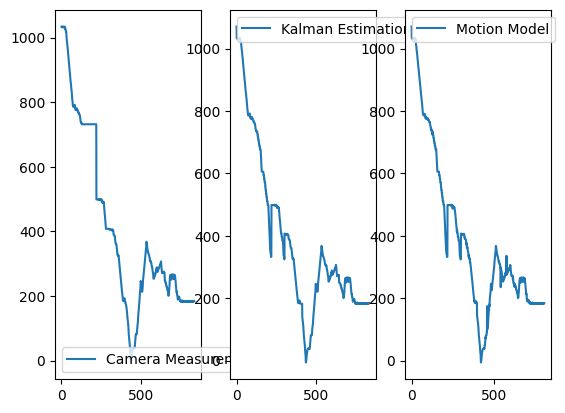

In [9]:
Kal = np.array(kalman_L)
Cam = np.array(camera_L)
Kal_motion = np.array(kalman_motion_modelL)
plt.subplot(1,3,1)
plt.plot(Cam[:,0],label="Camera Measurement")
plt.legend()
plt.subplot(1,3,2)
plt.plot(10*(Kal[:,0]),label="Kalman Estimation")
plt.legend()
plt.subplot(1,3,3)
plt.plot(10*(Kal_motion[1:,0]), label = "Motion Model")
plt.legend()

## 8. Conclusion

In this project, we have developed an environment where the Thymio Robot autonomously follows a path towards a goal. The system has five main components: Vision, Filtering, Control, Global Navigation, Local Obstacle Avoidance. 

While the Thymio is able to navigate freely in this system, being robust to local obstacles and kidnapping scenarios, it is important to note that this system is very sensitive to environmental changes. 

First, building a map through ArUco markers is not how it would be done out in the wild which makes our case already ideal in the fact it assumes that there are markers in the environment. The system is also sensitive to lighting as the HSV values are tuned to match the lighting of the room, if these conditions change, the global obstacle detection will become noisy which would affect all of the system. Moreover, the global obstacles are in 2D, which means that if the local avoidance brings the robot too close to a global obstacle, Thymio might not be able to avoid it.

On the filter side, as our motion model only has three states, when the camera is hidden, we are relying only on the motion model which means that the robot is bound to diverge and not reach the goal exactly if the camera is not unhidden at some point. One potential solution to that would be integrating more sensors already available on the Thymio such as accelerometers, IMU, ...

This project was extremely useful as it taught us how to bridge the gap between theory and application, but also how to build a pipeline from scratch and deal with the potential issues that might arise from it.